# NLP with GloVe embeddings and time

## Set-up

In [2]:
import os
import itertools
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.init import xavier_uniform_
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [3]:
os.chdir('..')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /cs/student/msc/ml/2020/sgeorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Need to specify device so that code can easily run on GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load training and dev data

In [6]:
train = pd.read_parquet('data/processed/train.parquet')
print(train.shape)

dev = pd.read_parquet('data/processed/dev.parquet')
print(dev.shape)

(749640, 13)
(92689, 13)


In [7]:
train.head()

,id_odsp,sort_order,time,text,event_type,event_team,opponent,is_goal,assist_method,fast_break,season,country,event_team_was_home
0,UFot0hit/,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,Attempt,Hamburg SV,Borussia Dortmund,0,Pass,0,2012,germany,0
1,UFot0hit/,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
2,UFot0hit/,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",Corner,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
3,UFot0hit/,4,7,Foul by Sven Bender (Borussia Dortmund).,Foul,Borussia Dortmund,Hamburg SV,0,None,0,2012,germany,1
4,UFot0hit/,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,Free kick won,Hamburg SV,Borussia Dortmund,0,None,0,2012,germany,0


In [8]:
# time_min_max_scalar = MinMaxScaler()
# time_min_max_scalar.fit(train[['time']])
# pickle.dump(time_min_max_scalar, open('models/time_min_max_scalar.pickle', 'wb'))

In [9]:
time_min_max_scalar = pickle.load(open('models/time_min_max_scalar.pickle', 'rb'))

In [10]:
def process_data_for_nlp(df):
    
    df = df.copy()
    
    # Sort by event order
    df.sort_values(['id_odsp', 'sort_order'], inplace=True)
    # Create target
    df['next_event_is_goal'] = df.groupby('id_odsp')['is_goal'].shift(-1)
    # Drop redundant columns
    df.drop(
        columns=['sort_order', 'event_type', 'event_team', 'opponent', 'assist_method', 'fast_break', 'season', 'country'], 
        inplace=True
    )
    # Drop entries with null target due to -1 shift
    df.dropna(subset=['next_event_is_goal'], axis=0, inplace=True)
    
    # Scale time
    df['time'] = time_min_max_scalar.transform(df[['time']])
    
    df.reset_index(drop=True, inplace=True)
    
    return df

In [11]:
train_p = process_data_for_nlp(train)
dev_p = process_data_for_nlp(dev)

train_p.shape, dev_p.shape

((742443, 6), (91789, 6))

In [12]:
train_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal
0,004f4ING/,0.01,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0,0.0
1,004f4ING/,0.01,Foul by Maya Yoshida (Southampton).,0,1,0.0
2,004f4ING/,0.05,Dusan Tadic (Southampton) wins a free kick on ...,0,1,0.0
3,004f4ING/,0.05,Foul by Neil Taylor (Swansea City).,0,0,0.0
4,004f4ING/,0.06,Attempt saved. James Ward-Prowse (Southampton)...,0,1,0.0


In [13]:
dev_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal
0,00nmICd9/,0.03,Foul by Juan Manuel FalcA³n (Metz).,0,1,0.0
1,00nmICd9/,0.03,TiemouA© Bakayoko (Monaco) wins a free kick in...,0,0,0.0
2,00nmICd9/,0.07,Foul by Anthony Martial (Monaco).,0,0,0.0
3,00nmICd9/,0.07,Sylvain Marchal (Metz) wins a free kick in the...,0,1,0.0
4,00nmICd9/,0.07,Foul by Cheick Doukoure (Metz).,0,1,0.0


## Tokenize text commentary

GloVe we are using is uncased so change all text to lower case:

In [14]:
def tokenize_text_commentary(df):
    df['text_lowercase'] = df['text'].str.lower()  # GloVe is lowercase
    df['text_split'] = df['text_lowercase'].apply(lambda x: word_tokenize(x))

In [15]:
%%time
tokenize_text_commentary(train_p)

CPU times: user 1min 37s, sys: 333 ms, total: 1min 37s
Wall time: 1min 37s


In [16]:
%%time
tokenize_text_commentary(dev_p)

CPU times: user 12.4 s, sys: 44.9 ms, total: 12.5 s
Wall time: 12.5 s


In [17]:
train_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal,text_lowercase,text_split
0,004f4ING/,0.01,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ..."
1,004f4ING/,0.01,Foul by Maya Yoshida (Southampton).,0,1,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]"
2,004f4ING/,0.05,Dusan Tadic (Southampton) wins a free kick on ...,0,1,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre..."
3,004f4ING/,0.05,Foul by Neil Taylor (Swansea City).,0,0,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]"
4,004f4ING/,0.06,Attempt saved. James Ward-Prowse (Southampton)...,0,1,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou..."


In [18]:
dev_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal,text_lowercase,text_split
0,00nmICd9/,0.03,Foul by Juan Manuel FalcA³n (Metz).,0,1,0.0,foul by juan manuel falca³n (metz).,"[foul, by, juan, manuel, falca³n, (, metz, ), .]"
1,00nmICd9/,0.03,TiemouA© Bakayoko (Monaco) wins a free kick in...,0,0,0.0,tiemoua© bakayoko (monaco) wins a free kick in...,"[tiemoua©, bakayoko, (, monaco, ), wins, a, fr..."
2,00nmICd9/,0.07,Foul by Anthony Martial (Monaco).,0,0,0.0,foul by anthony martial (monaco).,"[foul, by, anthony, martial, (, monaco, ), .]"
3,00nmICd9/,0.07,Sylvain Marchal (Metz) wins a free kick in the...,0,1,0.0,sylvain marchal (metz) wins a free kick in the...,"[sylvain, marchal, (, metz, ), wins, a, free, ..."
4,00nmICd9/,0.07,Foul by Cheick Doukoure (Metz).,0,1,0.0,foul by cheick doukoure (metz).,"[foul, by, cheick, doukoure, (, metz, ), .]"


In [19]:
# Combine all token lists together and find set to get vocab
vocab_set = set(
    itertools.chain.from_iterable(
        list(train_p['text_split'])
    )
)

In [20]:
len(vocab_set)

6468

In [21]:
# Create token to index dict
word_to_idx = dict(
    zip(
        vocab_set, 
        range(  # Start index from 1 as we reserve the 0 index for the padding vector
            1,
            len(vocab_set)+1
        )
    )
)

In [22]:
%%time
# For each sentence in training map tokens to corresponding index
train_p['token_sequence'] = [[word_to_idx[token] for token in commentary] for commentary in list(train_p['text_split'])]

CPU times: user 2.19 s, sys: 34 ms, total: 2.22 s
Wall time: 2.23 s


In [23]:
train_p.head()

,id_odsp,time,text,is_goal,event_team_was_home,next_event_is_goal,text_lowercase,text_split,token_sequence
0,004f4ING/,0.01,Bafetimbi Gomis (Swansea City) wins a free kic...,0,0,0.0,bafetimbi gomis (swansea city) wins a free kic...,"[bafetimbi, gomis, (, swansea, city, ), wins, ...","[3813, 6148, 6005, 5894, 5128, 4920, 4048, 101..."
1,004f4ING/,0.01,Foul by Maya Yoshida (Southampton).,0,1,0.0,foul by maya yoshida (southampton).,"[foul, by, maya, yoshida, (, southampton, ), .]","[5356, 3613, 5605, 4756, 6005, 4860, 4920, 3860]"
2,004f4ING/,0.05,Dusan Tadic (Southampton) wins a free kick on ...,0,1,0.0,dusan tadic (southampton) wins a free kick on ...,"[dusan, tadic, (, southampton, ), wins, a, fre...","[1611, 2074, 6005, 4860, 4920, 4048, 1019, 237..."
3,004f4ING/,0.05,Foul by Neil Taylor (Swansea City).,0,0,0.0,foul by neil taylor (swansea city).,"[foul, by, neil, taylor, (, swansea, city, ), .]","[5356, 3613, 517, 3405, 6005, 5894, 5128, 4920..."
4,004f4ING/,0.06,Attempt saved. James Ward-Prowse (Southampton)...,0,1,0.0,attempt saved. james ward-prowse (southampton)...,"[attempt, saved, ., james, ward-prowse, (, sou...","[2994, 4500, 3860, 446, 3724, 6005, 4860, 4920..."


In [24]:
MAX_LENGTH = np.max([len(seq) for seq in train_p['token_sequence']])  # Max length of tokens for any sentence in the training data
MAX_LENGTH

50

In [25]:
def pad_sentence(sentence_seq, max_length=MAX_LENGTH):
    """
    Takes a list of numbers representing a sentence and appends zeros to the list until `max_length` is achieved.
    """
    if len(sentence_seq) < max_length:
        num_zeros_to_add = max_length - len(sentence_seq)
        zeros_list = list(np.zeros(num_zeros_to_add))
        zeros_list = [int(x) for x in zeros_list]  # Convert zeros to int
        
        sentence_seq = sentence_seq + zeros_list
        
    return sentence_seq

In [26]:
class CommentaryDataset(Dataset):

    def __init__(self, data, word_to_idx, max_length=MAX_LENGTH):
        """
        """
        data = data.copy()
        
        # Initial pre-processing
        data = process_data_for_nlp(data)
        
        # Tokenise text commentary
        tokenize_text_commentary(data)
        
        # Look up each token in word_to_index (from training) and get index value or drop if not in dictionary
        data['token_sequence'] = [
            [word_to_idx.get(token) for token in commentary if word_to_idx.get(token) != None] for commentary in list(data['text_split'])
        ]
        
        # Trim to length
        data['token_sequence'] = [token_sequence[:max_length] for token_sequence in list(data['token_sequence'])]
        
        # Pad sentences
        data['token_sequence'] = [pad_sentence(token_sequence) for token_sequence in data['token_sequence']]
        
        # Lagged features
        for i in range(1,5):
            data[f'token_sequence_minus_{i}'] = data.groupby('id_odsp')['token_sequence'].shift(i)
            data[f'time_minus_{i}'] = data.groupby('id_odsp')['time'].shift(i)
            data[f'is_goal_minus_{i}'] = data.groupby('id_odsp')['is_goal'].shift(i)
            
        data.dropna(axis=0, how='any', inplace=True)  # Drop rows with empty features caused by lag
        
        token_sequence = ['token_sequence'] + [f'token_sequence_minus_{i}' for i in range(1, 5)]
        token_sequence.reverse()  # Order from furthest away to most recent
        self.token_sequence = np.array(data[token_sequence].values.tolist())  # Create 3D matrix of token sequences of shape (batch size, timesteps, tokens)
        
        time = ['time'] + [f'time_minus_{i}' for i in range(1, 5)]
        time.reverse()
        self.time = data[time].values
        
        goal = ['is_goal'] + [f'is_goal_minus_{i}' for i in range(1, 5)]
        goal.reverse()
        self.goal = data[goal].values
        
        self.event_team_was_home = data['event_team_was_home'].values
        
        self.y = data['next_event_is_goal'].values

    def __len__(self):
        return self.token_sequence.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.token_sequence[idx, :, :], self.time[idx, :], self.goal[idx, :], self.event_team_was_home[idx], self.y[idx]

In [27]:
%%time
train_comm = CommentaryDataset(train, word_to_idx)

CPU times: user 2min 3s, sys: 1.15 s, total: 2min 4s
Wall time: 2min 4s


In [28]:
%%time
dev_comm = CommentaryDataset(dev, word_to_idx)

CPU times: user 15.3 s, sys: 120 ms, total: 15.4 s
Wall time: 15.4 s


## Load pre-trained GloVe embeddings

In [29]:
%%time
word_to_vector = {}
with open('data/external/glove.6B.100d.txt', "r") as f:
    # Each line starts with the word/character followed by the 100d vector representation
    for line in f:
        
        # Split by whitespace:
        components = line.split()
        
        word = components[0]
        vector_values = components[1:]
        
        vector_array = np.array(vector_values, dtype=np.float64)  # Convert vector to numpy array
        
        # Add to dictionary
        word_to_vector[word] = vector_array

CPU times: user 6.83 s, sys: 213 ms, total: 7.04 s
Wall time: 6.96 s


In [30]:
len(word_to_vector.keys())

400000

In [31]:
word_to_vector['foul']

array([ 8.8509e-01, -8.0413e-01,  7.3326e-01, -1.1997e+00, -4.4433e-01,
        9.9010e-01, -1.1211e-01, -7.0893e-01, -1.4639e-01, -1.9667e-01,
       -1.4831e-01, -1.0859e-01, -3.9821e-01, -4.9383e-01,  1.0474e+00,
        6.4321e-01, -6.4378e-01, -2.7974e-01, -4.2865e-01,  5.5361e-02,
        2.1271e-01,  6.2063e-01,  1.1255e-01, -9.9549e-02,  5.2189e-01,
       -2.9921e-01, -6.3453e-01,  5.5675e-01,  1.0460e-01, -1.0456e-01,
        3.0833e-02, -1.0498e-03,  5.6656e-01, -1.1333e-01, -5.8664e-02,
       -5.9103e-01, -2.2791e-01,  3.2208e-01,  6.9484e-02,  3.6374e-01,
       -3.4399e-01,  3.3388e-02,  1.2079e-01, -6.0931e-01, -3.2988e-01,
        5.1176e-02, -3.5307e-01, -4.5887e-02, -2.0085e-01, -6.6991e-01,
        4.3831e-01,  3.8817e-01, -9.4224e-01,  5.2481e-01, -7.7710e-02,
       -1.3177e+00, -1.2479e-01,  3.3277e-01,  1.1003e+00,  4.8362e-01,
       -3.4234e-01,  1.5704e-01, -6.7879e-01,  4.4289e-01, -1.7270e-01,
       -5.3625e-01,  1.0005e+00, -9.6411e-01, -1.2487e+00, -1.94

## Create embedding matrix

In [32]:
GLOVE_DIMENSION = 100

In [33]:
# Create empty matrix for embedding matrix
embedding_matrix = np.zeros(
    (
        len(vocab_set) + 1,  # Additional 1 for zero vector for padding
        GLOVE_DIMENSION
    )
)
embedding_matrix.shape

(6469, 100)

In [34]:
len(word_to_idx.keys())

6468

In [35]:
for word, idx in word_to_idx.items():
    try:
        embedding_matrix[idx, :] = word_to_vector[word]
    except KeyError:  # Word in training set not in GloVe
        embedding_matrix[idx, :] = np.zeros(GLOVE_DIMENSION)  # We replace unknown words with zeros

In [36]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.22825  , -0.35789  , -0.045921 , ...,  0.90784  , -0.6716   ,
        -0.98099  ],
       [ 0.14814  , -0.27723  , -0.90581  , ..., -0.37967  , -0.22567  ,
         0.0015809],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.42538  ,  0.071226 , -0.28185  , ..., -1.011    , -0.83924  ,
        -0.44538  ]])

In [37]:
np.sum(embedding_matrix.sum(axis=1) == 0)  # Number of words in vocab but not in GloVe

1885

In [38]:
# Convert to tensor for PyTorch
embedding_tensor = torch.from_numpy(embedding_matrix)
embedding_tensor = embedding_tensor.to(device)

## Train model

In [39]:
train_comm.token_sequence[:,1,:].shape

(713655, 50)

In [40]:
train_comm.event_team_was_home.shape

(713655,)

In [41]:
train_comm.goal.shape

(713655, 5)

In [42]:
train_comm.time.shape

(713655, 5)

In [43]:
train_comm.y.shape

(713655,)

In [44]:
class NextEventIsGoal(nn.Module):

    def __init__(self):
        super(NextEventIsGoal, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embeddings=embedding_tensor, freeze=False)
        # LSTM
        self.lstm_sentences = nn.LSTM(input_size=GLOVE_DIMENSION, hidden_size=125, batch_first=True)
        self.lstm_features = nn.LSTM(input_size=125+2, hidden_size=300, batch_first=True)
        
        # MLP
        self.fc_1 = nn.Linear(in_features=300+1, out_features=125)
        self.fc_2 = nn.Linear(in_features=125, out_features=1)

        xavier_uniform_(self.fc_1.weight)  # in-place
        xavier_uniform_(self.fc_2.weight)  # in-place        
        
        self.dropout = nn.Dropout(p=0)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, token_sequence, event_team_was_home, goal, time):
        
        x = self.embedding(token_sequence[:,0,:])
        x = x.float()
        all_h_t, _ = self.lstm_sentences(x)
        h_T0 = all_h_t[:, -1, :]  # Final cell outputs
        
        x = self.embedding(token_sequence[:,1,:])
        x = x.float()
        all_h_t, _ = self.lstm_sentences(x)
        h_T1 = all_h_t[:, -1, :]  # Final cell outputs
        
        x = self.embedding(token_sequence[:,2,:])
        x = x.float()
        all_h_t, _ = self.lstm_sentences(x)
        h_T2 = all_h_t[:, -1, :]  # Final cell outputs
        
        x = self.embedding(token_sequence[:,3,:])
        x = x.float()
        all_h_t, _ = self.lstm_sentences(x)
        h_T3 = all_h_t[:, -1, :]  # Final cell outputs
        
        x = self.embedding(token_sequence[:,4,:])
        x = x.float()
        all_h_t, _ = self.lstm_sentences(x)
        h_T4 = all_h_t[:, -1, :]  # Final cell outputs
        
        sentence_representation_over_time = torch.stack(
            (h_T0, h_T1, h_T2, h_T3, h_T4),
            dim=1  # Put timesteps on axis 1
        )
        
        goal_and_mins_over_time = torch.stack(
            (goal, time),
            dim=2  # Feautures as 3rd dimension
        )
        
        x = torch.cat(
            (sentence_representation_over_time, goal_and_mins_over_time), 
            dim=2
        )
        
        del sentence_representation_over_time, goal_and_mins_over_time
        
        x = x.float()
        
        all_h_t, _ = self.lstm_features(x)
        h_T = all_h_t[:, -1, :]  # Final cell outputs
        
        x = torch.cat((h_T, event_team_was_home.reshape(-1, 1)), dim=1)
        
        x = self.fc_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)

        x = self.sigmoid(x)
        
        return x

In [45]:
model = NextEventIsGoal()
model.to(device)

NextEventIsGoal(
  (embedding): Embedding(6469, 100)
  (lstm_sentences): LSTM(100, 125, batch_first=True)
  (lstm_features): LSTM(127, 300, batch_first=True)
  (fc_1): Linear(in_features=301, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [46]:
model.named_parameters

<bound method Module.named_parameters of NextEventIsGoal(
  (embedding): Embedding(6469, 100)
  (lstm_sentences): LSTM(100, 125, batch_first=True)
  (lstm_features): LSTM(127, 300, batch_first=True)
  (fc_1): Linear(in_features=301, out_features=125, bias=True)
  (fc_2): Linear(in_features=125, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>

In [47]:
# https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
sum(p.numel() for p in model.parameters() if p.requires_grad)

1313076

In [56]:
criterion = nn.BCELoss()
optimiser = optim.Adam(params=model.parameters(), lr=0.00003)

Use subset of training data otherwise takes forever...

In [49]:
len(train_comm)

713655

In [50]:
# num_subset_examples = 50000

# train_ncd_subset = torch.utils.data.Subset(
#     train_comm, 
#     indices=np.random.choice(
#         range(len(train_comm)), 
#         num_subset_examples
#     )
# )

In [52]:
training_losses = []
dev_losses = []
training_rocaucs = []
dev_rocaucs = []

In [57]:
%%time
for epoch in range(5):
    for data in tqdm(DataLoader(train_comm, batch_size=1024, shuffle=True)):
        
        token_sequence, time, goal, event_team_was_home, y = data
        token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)

        optimiser.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = model(token_sequence, event_team_was_home, goal, time)
        loss = criterion(y_pred, y.float())

        loss.backward()
        optimiser.step()
        
        del token_sequence, time, goal, event_team_was_home, y
    
    # Training loss
    with torch.no_grad():  # Uses less memory
        y_train_list = []
        y_pred_list = []
        
        training_loss_total = 0
        for data in DataLoader(train_comm, batch_size=1024):
            token_sequence, time, goal, event_team_was_home, y = data
            token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)

            y_pred = model(token_sequence, event_team_was_home, goal, time)

            batch_loss_sum = float(
                nn.BCELoss(reduction='sum')(y_pred, y.float())
            )
            training_loss_total += batch_loss_sum
            
            y_train_list.append(y.detach().cpu().numpy())
            y_pred_list.append(y_pred.detach().cpu().numpy())

        loss = training_loss_total / len(train_comm)
        training_losses.append(loss)
        
        y_train = np.concatenate(y_train_list, axis=0)
        y_pred = np.concatenate(y_pred_list, axis=0)

        train_rocauc = roc_auc_score(y_train, y_pred)
        training_rocaucs.append(train_rocauc)
        
    # Dev loss
    with torch.no_grad():  # Uses less memory
        y_dev_list = []
        y_pred_list = []
        
        dev_loss_total = 0
        for data in DataLoader(dev_comm, batch_size=1024):
            token_sequence, time, goal, event_team_was_home, y = data
            token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)

            y_pred = model(token_sequence, event_team_was_home, goal, time)

            batch_loss_sum = float(
                nn.BCELoss(reduction='sum')(y_pred, y.float())
            )
            dev_loss_total += batch_loss_sum
            
            y_dev_list.append(y.detach().cpu().numpy())
            y_pred_list.append(y_pred.detach().cpu().numpy())

        loss = dev_loss_total / len(dev_comm)
        dev_losses.append(loss)
        
        y_dev = np.concatenate(y_dev_list, axis=0)
        y_pred = np.concatenate(y_pred_list, axis=0)

        dev_rocauc = roc_auc_score(y_dev, y_pred)
        dev_rocaucs.append(dev_rocauc)
    
    print(f'Epoch: {epoch+1}, train_loss: {training_losses[-1]}, dev_loss: {dev_losses[-1]}, train_rocauc: {training_rocaucs[-1]}, dev_rocauc: {dev_rocaucs[-1]}')

  0%|          | 0/697 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.11463612275034363, dev_loss: 0.11677600040593027, train_rocauc: 0.6654704197944338, dev_rocauc: 0.6629106264227688


  0%|          | 0/697 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.11455440290724342, dev_loss: 0.11665464654140915, train_rocauc: 0.6711377573092601, dev_rocauc: 0.6685805427172506


  0%|          | 0/697 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.11416584490116125, dev_loss: 0.11634834312130377, train_rocauc: 0.6746588341076117, dev_rocauc: 0.6710592913356679


  0%|          | 0/697 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.11344140266587208, dev_loss: 0.11559271357440645, train_rocauc: 0.6763466292360774, dev_rocauc: 0.6705481212191466


100%|██████████| 697/697 [11:06<00:00,  1.05it/s]


Epoch: 5, train_loss: 0.11283330448241852, dev_loss: 0.1149016191076176, train_rocauc: 0.6768540180145345, dev_rocauc: 0.6704882117514024
CPU times: user 50min 20s, sys: 23min 18s, total: 1h 13min 39s
Wall time: 1h 13min 40s


<Figure size 576x432 with 0 Axes>

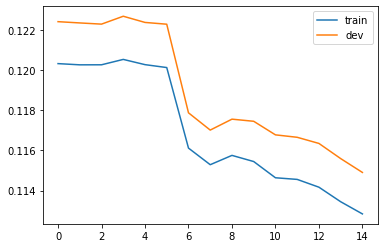

In [58]:
plt.figure(figsize=(8, 6))
pd.DataFrame({'train': training_losses, 'dev': dev_losses}).plot()
plt.show()

<Figure size 576x432 with 0 Axes>

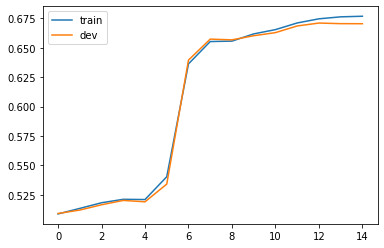

In [59]:
plt.figure(figsize=(8, 6))
pd.DataFrame({'train': training_rocaucs, 'dev': dev_rocaucs}).plot()
plt.show()

## Training ROCAUC

In [60]:
y_train_list = []
y_pred_list = []

for data in tqdm(DataLoader(train_comm, batch_size=2048)):
    token_sequence, time, goal, event_team_was_home, y = data
    token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)
    
    with torch.no_grad():
        y_pred = model(token_sequence, event_team_was_home, goal, time)

    y_train_list.append(y.detach().cpu().numpy())
    y_pred_list.append(y_pred.detach().cpu().numpy())

100%|██████████| 349/349 [03:18<00:00,  1.76it/s]


In [61]:
y_train = np.concatenate(y_train_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [62]:
roc_auc_score(y_train, y_pred)

0.6768540180145345

## Dev ROCAUC

In [64]:
y_dev_list = []
y_pred_list = []

for data in tqdm(DataLoader(dev_comm, batch_size=2048)):
    token_sequence, time, goal, event_team_was_home, y = data
    token_sequence, time, goal, event_team_was_home, y = token_sequence.to(device), time.to(device), goal.to(device), event_team_was_home.to(device), y.reshape(-1,1).to(device)
    
    with torch.no_grad():
        y_pred = model(token_sequence, event_team_was_home, goal, time)
    
    y_dev_list.append(y.detach().cpu().numpy())
    y_pred_list.append(y_pred.detach().cpu().numpy())

100%|██████████| 44/44 [00:24<00:00,  1.79it/s]


In [65]:
y_dev = np.concatenate(y_dev_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

In [66]:
roc_auc_score(y_dev, y_pred)

0.6704882117514024